### JASON collision model plot

Make plots using the JASON simplified collision model 
This reproduces Fig. 20 of the JASON report on megaconstellations 

(i) Active satellites vs time  
(ii) Derelicts vs time  
(iii) Lethal debris vs time

On separate axis, plot cumulative collisions vs time

Divide debris collisions into 
minor = 1mm too 1cm  
disabling = 1cm to 10cm  
lethal = larger than 10cm  

Solve for time varying quantities:   
$S$ = number of live satellites  
$D$ = number of derelict satellites  
$N$ = number of lethal debris objects

$n=N/V$ = number density of lethal debris  
$n0$ = starting density of lethal debris  
(this is used because assumed to stay the same in the shell above,
and some debris drifts down)

To use the JASON rate equations, don't need to convert everything to SI, but do
need to use consistent units:  

time in years  
lengths in km  
speed in km/yr  
cross-section in km^2  
number density in km^-3  
shell volume in km^3  

Collisions:  rate is just $r=n\sigma v$ per object  
if units are as above then $r$ is in units of number per year.  

Here $n$ is number density of impactors, i.e. Debris,
and so ignoring satellite-satellite collisions. 
collisions per year is $r(S+D)$

Note that this is lethal collisions, producing more fragments. The model assumes that the number of
disabling fragments is $\delta$ times as many. This determines the rate at which derelicts are made. Note that the model assumes that derelicts can't avoid collisions at all, and even the live satellites fail to avoid some fraction of collisions.


In [6]:
from math import *
import numpy as np
from matplotlib import pyplot as plt

# pick a plotting option
# inline is default; in Binder version may need to comment out all of them
% matplotlib inline 
#% matplotlib osx
#% matplotlib qt
#% matplotlib --list

Set parameters for model in natural units but immediately convert to our standard units as above

In [7]:
lamda = 10000    # launches per year

sigma = 10  # collision cross-section per satellite in m^2
sigma = sigma/(1000.*1000) # now in km^2

v = 10 # typical relative velocity km/s
v = v * 3600.*24*365  # now km/yr

delt = 5 # satellite lifetime in yrs
N0 = 100 # number of lethal debris fragments created in a collision
delta = 10 # ratio of disabling to lethal debris objects  
alpha = 0.2 # fraction of lethal collisions not avoided
P = 0.95 # post mission disposal probability
tau = 5 # atmospheric drag lifetime in yrs

n0=2.5E-8 # current number density of lethal objects km^-3

dh=25 # shell thickness in km
h=600 # shell height in km
RE=6378 # radius of Earth in km

R=RE+h
V=4.*pi*R*R*dh  # shell volume in km^3


Set up time array and initialise time  varying quantities. Set finite value for first element to prevent blow-up.

In [8]:
t0=0.0
tmax=50.0  # in years
tstep= 0.1
tarray = np.arange(t0,tmax,tstep)

S=np.zeros(len(tarray)); S[0]=0.01
D=np.zeros(len(tarray)); D[0]=0.01
n=np.zeros(len(tarray))
n=n+n0 # initialise debris density at n0
N=n*V
# cumulative disabling plus lethal collisions
Ccoll=np.zeros(len(tarray)); Ccoll[0]=0.001    

logS=np.zeros(len(tarray)); logS[0]=log10(S[0])
logD=np.zeros(len(tarray)); logD[0]=log10(D[0])
logN=np.zeros(len(tarray)); logN[0]=log10(N[0])
logCcoll=np.zeros(len(tarray)); logCcoll[0]=log10(Ccoll[0])




Loop through time; calculate rates; increment values.

In [9]:
for i in range(0,(len(tarray)-1)):
    Sdot = lamda  - S[i]/delt - (delta+alpha)*n[i]*sigma*v*S[i]
    S[i+1]=S[i]+Sdot*tstep
    logS[i+1]=log10(S[i+1])
    
    Ddot = (1.-P)*S[i]/delt + delta*n[i]*sigma*v*S[i] - n[i]*sigma*v*D[i] -D[i]/tau
#    print(i,S[i],S[i+1],Ddot)
    D[i+1]=D[i]+Ddot*tstep
    logD[i+1]=log10(D[i+1])

    Ndot = n[i]*sigma*v*N0*(alpha*S[i]+D[i]) +n0*V/tau - N[i]/tau
    N[i+1]=N[i]+Ndot*tstep
    n[i+1]=N[i+1]/V
    logN[i+1]=log10(N[i+1])
    
    dC=n[i]*sigma*v*tstep* (S[i]*(alpha+delta) + D[i]) # collisions in this timestep
    Ccoll[i+1]=Ccoll[i]+dC # collisions so far
    logCcoll[i+1]=log10(Ccoll[i+1])


Now make the plot; use logarithmic version, as per JASON report.

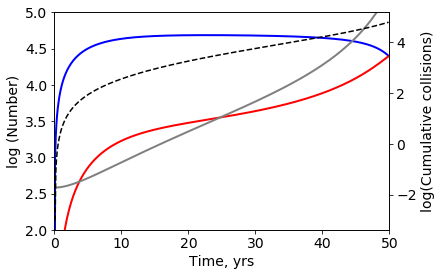

In [10]:
ymin=2.0
ymax=5.0
xmin=0.0
xmax=50.0
#Cmult=100.; not needed now...
#logCmult=log10(Cmult)

fig, ax1 = plt.subplots()
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])

# satellites
ax1.plot(tarray,logS, color='blue', lw=2.0)
# derelicts
ax1.plot(tarray,logD, color='red', lw=2.0)
# lethal debris
ax1.plot(tarray,logN, color='gray', lw=2.0)

ax1.tick_params(labelsize=14)
ax1.set_xlabel('Time, yrs', size=14)
ax1.set_ylabel('log (Number)', size=14)


ax2=ax1.twinx()
ax2.plot(tarray,logCcoll, '--',color='black')
ax2.set_ylabel('log(Cumulative collisions)', size=14)
ax2.tick_params(labelsize=14)


plt.show()